In [1]:
# Standard DS & plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import (
    preprocess_text, 
    compute_coherence, 
    plot_wordclouds,
    plot_common_words,
    plot_coefficients, 
    prepare_data, 
    compile_model, 
    plot_training_curve
)

# NLP libraries
import gensim.corpora as corpora
from textblob import TextBlob

from gensim.models import wrappers
import pyLDAvis.gensim

# Classic ML 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline 

# Deep learning 
from keras.callbacks import LearningRateScheduler

# Serialization
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
positive = pd.read_csv('data/positive.tsv', sep='\t', index_col=0)
positive['target'] = 1
negative = pd.read_csv('data/negative.tsv', sep='\t', index_col=0)
negative['target'] = 0

## Checking null values

In [3]:
positive.isnull().sum()

Title          0
Abstract    2016
target         0
dtype: int64

In [4]:
negative.isnull().sum()

Title       0
Abstract    0
target      0
dtype: int64

A lot of positive articles contain only Title. Therefore we'll need to concatenate Title & Abstract together to analyze them together.

In [5]:
data_raw = positive.append(negative)

In [6]:
data_raw['concat'] = data_raw.Title.map(str) + " " + data_raw.Abstract.fillna(' ').map(str)

In [7]:
# data = preprocess_text(data_raw)

In [8]:
# shortcut for preprocessing
import ast

data = pd.read_csv('./data/clean_joined.csv')
data['lemmatized'] = data['lemmatized'].apply(ast.literal_eval)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['lemma_str'], data['target'], test_size=0.1, random_state=42)

# 1. Text length

In [26]:
data['counts_title'] = data['Title'].str.split().apply(len)
data['counts_abstract'] = data['Abstract'].fillna('').str.split().apply(len)
data['counts'] = data['concat'].fillna('').str.split().apply(len)

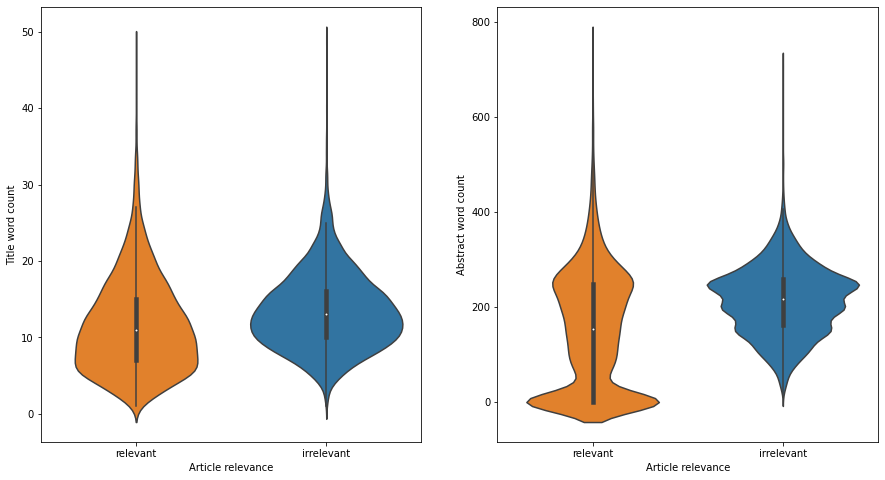

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.violinplot(x='target', y='counts_title', data=data, ax=ax[0])
ax[0].set(ylabel="Title word count", xlabel="Article relevance", xticklabels=['irrelevant', 'relevant'])
ax[0].invert_xaxis()
sns.violinplot(x='target', y='counts_abstract', data=data, ax=ax[1])
ax[1].set(ylabel="Abstract word count", xlabel="Article relevance", xticklabels=['irrelevant', 'relevant'])
ax[1].invert_xaxis()

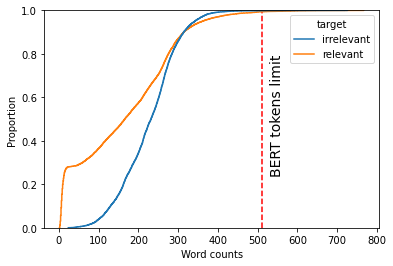

In [28]:
g = sns.ecdfplot(x='counts', hue='target', data=data)
line = g.vlines(512, 0, 1, color='r', linestyle='--', label='BERT tokens limit')
g.set(xlabel="Word counts")
new_labels = ['irrelevant', 'relevant']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
g.text(530,0.25,'BERT tokens limit', rotation=90, fontsize=14);

Apart from `NA` values in positive abstracts, Titles and Abstracts of irrelevant articles are longer. Because of high percent of missing data in Abstracts of positive articles further analysis concentrates on concatenated text.

# 2. Text data preprocessing

## Sentiment analysis

In [9]:
data['sentiment'] = data['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

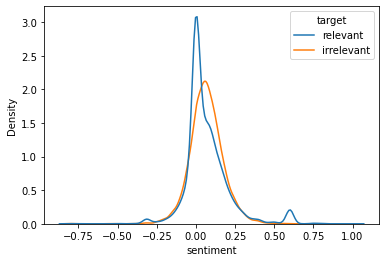

In [10]:
g = sns.kdeplot(x='sentiment', hue='target', hue_order = [1, 0], data=data)
new_labels = ['relevant', 'irrelevant']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l);

Obviously, there are not much sentiment indicating words used in scientific articles, but we see an outlier in the positive group, lets see this abstract

In [17]:
data.loc[data['sentiment'] >= 0.8, 'concat'].values[2:]

array(['Increasing mortality due to end-stage liver disease in patients with human immunodeficiency virus infection Highly active antiretroviral therapy has decreased human immunodeficiency virus (HIV)-associated mortality; other comorbidities, such as chronic liver disease, are assuming greater importance. We retrospectively examined the causes of death of HIV-seropositive patients at our institution in 1991, 1996, and 1998-1999. In 1998-1999, 11 (50%) of 22 deaths were due to end-stage liver disease, compared with 3 (11.5%) of 26 in 1991 and 5 (13.9%) of 36 in 1996 (P=.003). In 1998-1999, 55% of patients had nondetectable plasma HIV RNA levels and/or CD4 cell counts of >200 cells/mm(3) within the year before death. Most of the patients that were tested had detectable antibodies to hepatitis C virus (75% of patients who died in 1991, 57.7% who died in 1996, and 93.8% who died in 1998-1999; P=NS). In 1998-1999, 7 patients (31.8%) discontinued antiretroviral therapy because of hepatotox

Positive sentiments contain words such as **best** or **greater**. 

In [19]:
data.loc[data['sentiment'] <= -0.8, 'concat'].values

array(['Colchicine intoxication. A reappraisal of its pathology based on a study of three fatal cases  ',
       'Liver disorders in patients receiving chlorpromazine or isoniazid Based on information derived from computers and clinical records obtained from general practitioners in the United Kingdom, we estimated the frequency of liver toxicity associated with two known hepatotoxins, chlorpromazine and isoniazid. Among the cohort of 10,502 users of chlorpromazine, 14 had illnesses compatible with drug-induced liver disease, a frequency of 1.3/1000 users (95% Cl 0.8, 2.2). Four presumed cases of the disorder occurred among 921 users of isoniazid, for a frequency of 4/1000 users (95% Cl 1.7, 11.1). This study provides population-based quantification of the frequency of liver disorders associated with the use of these two agents.',
       'A new chromene from the fruiting bodies of Chroogomphus rutilus A new chromene, acetic acid 2R-(4,8-dimethylnona-3,7-dienyl)-8-hydroxy-2-methyl-2H-ch

Negative sentiments contain words such as **fatal** or **death**. However, `TextBlob` was not accurate in predicting actual sentiment. 

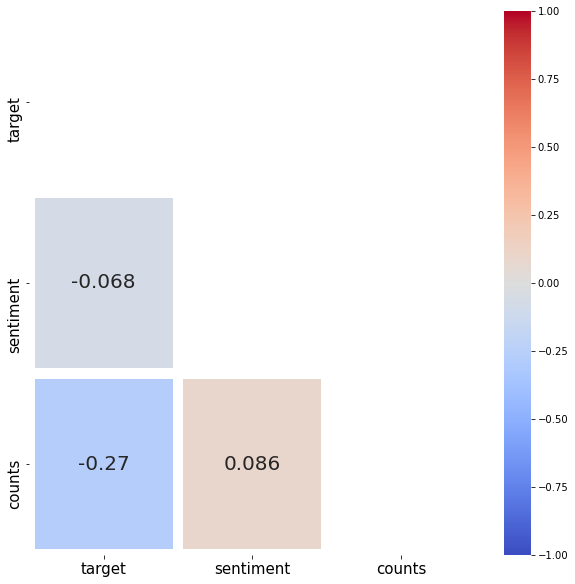

In [29]:
correlation = data[['target','sentiment', 'counts']].corr(method='spearman')
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 20}, linewidths=10, vmin=-1, vmax=1, mask=mask);

Text length is inversely correlated with target - as a lot of positive articles are shorter because of lack of the abstract (2016/7177 entries). It is not clear if this feature would be useful for a holdout set.

## Word clouds

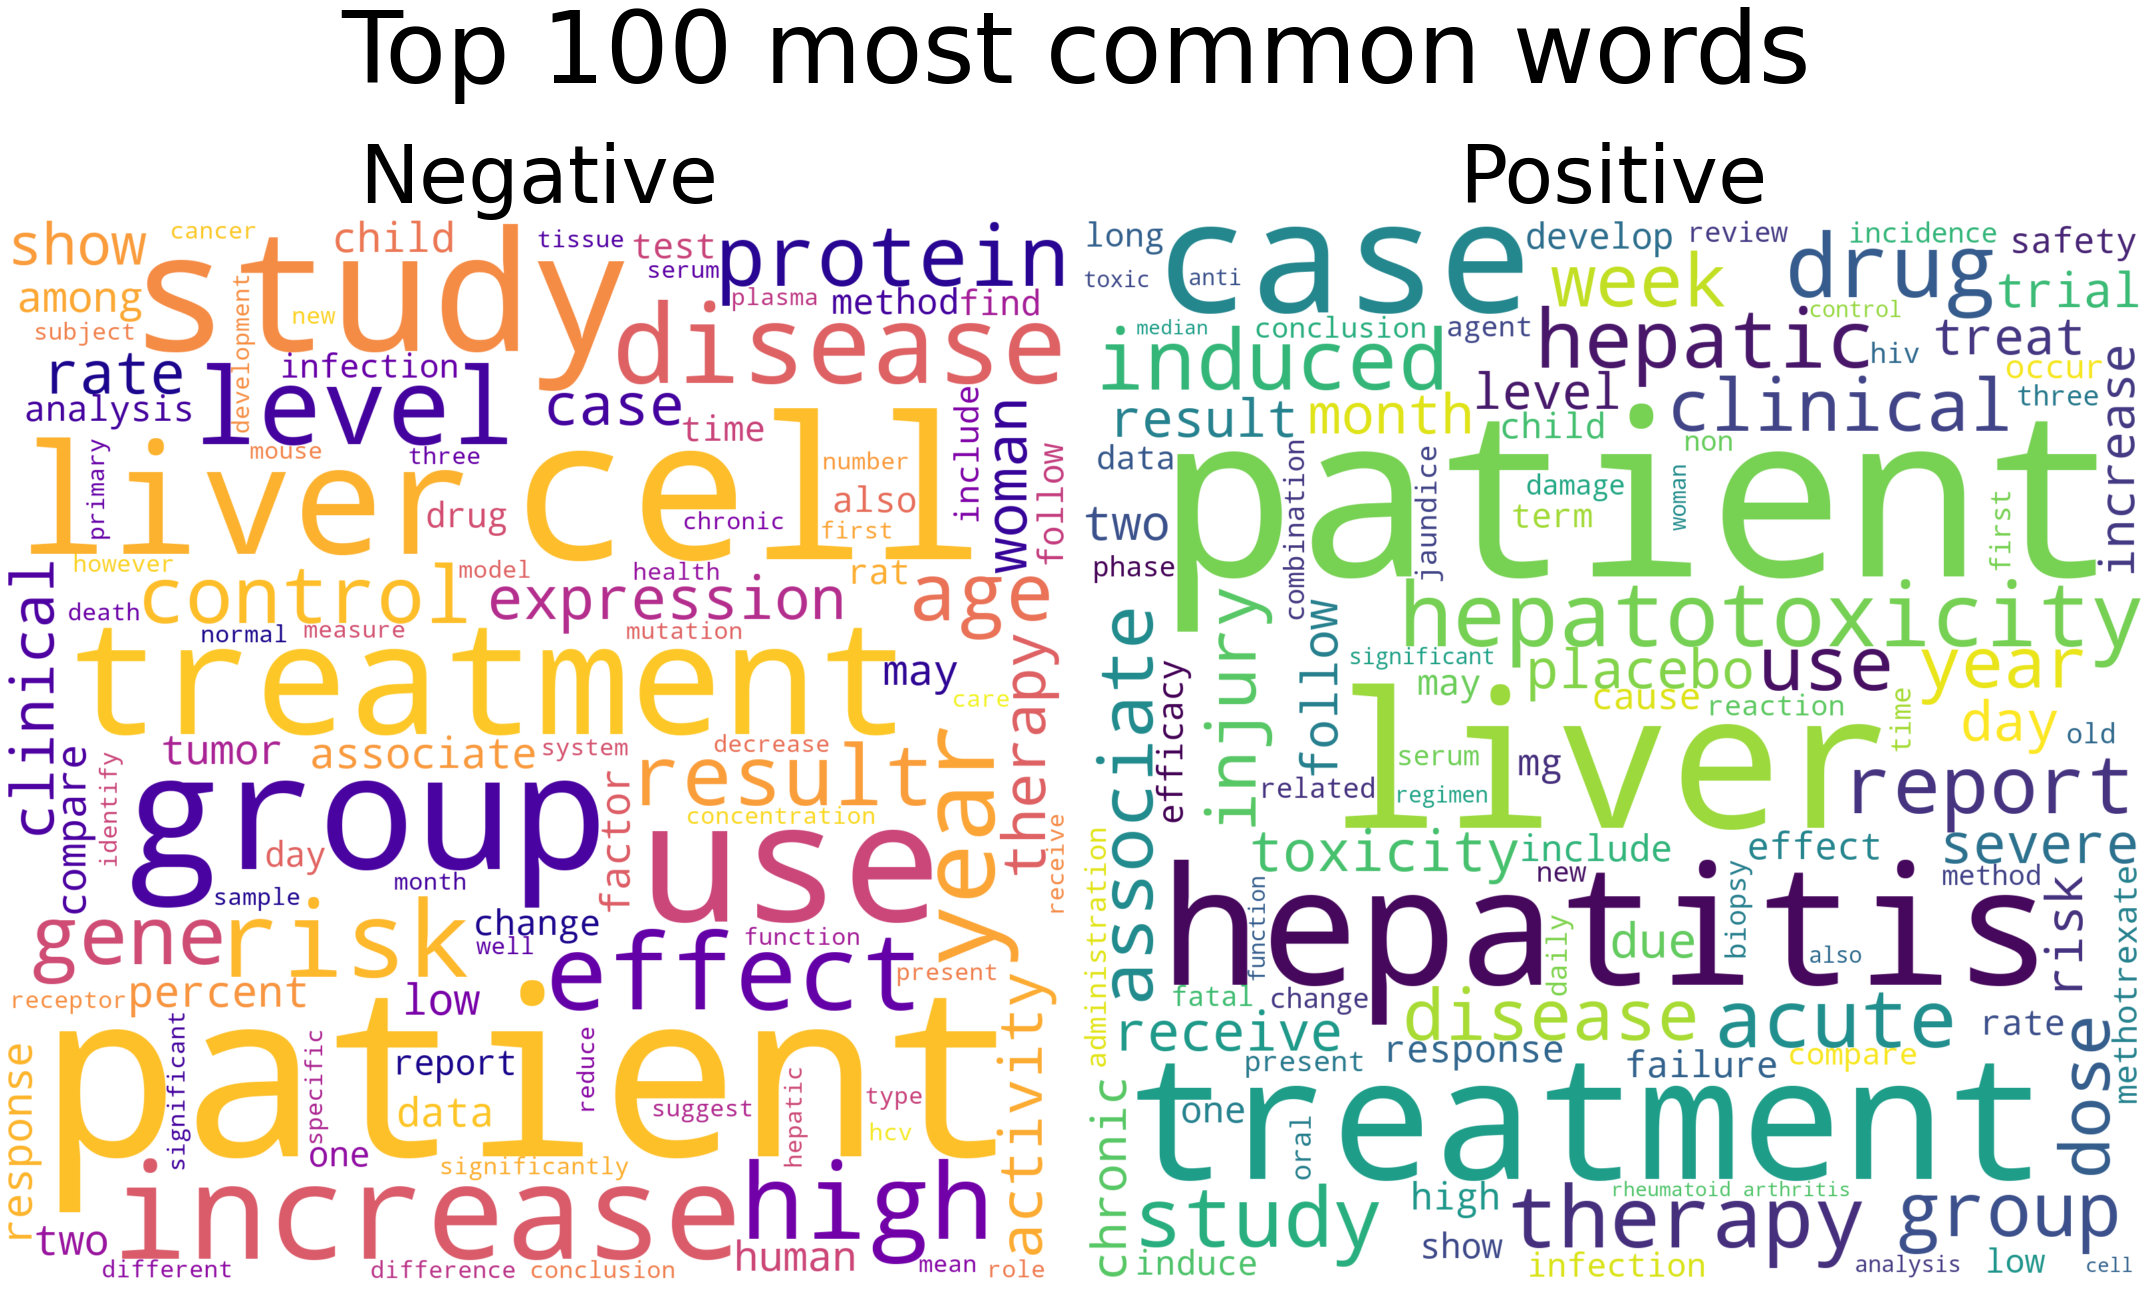

In [37]:
plot_wordclouds(data)

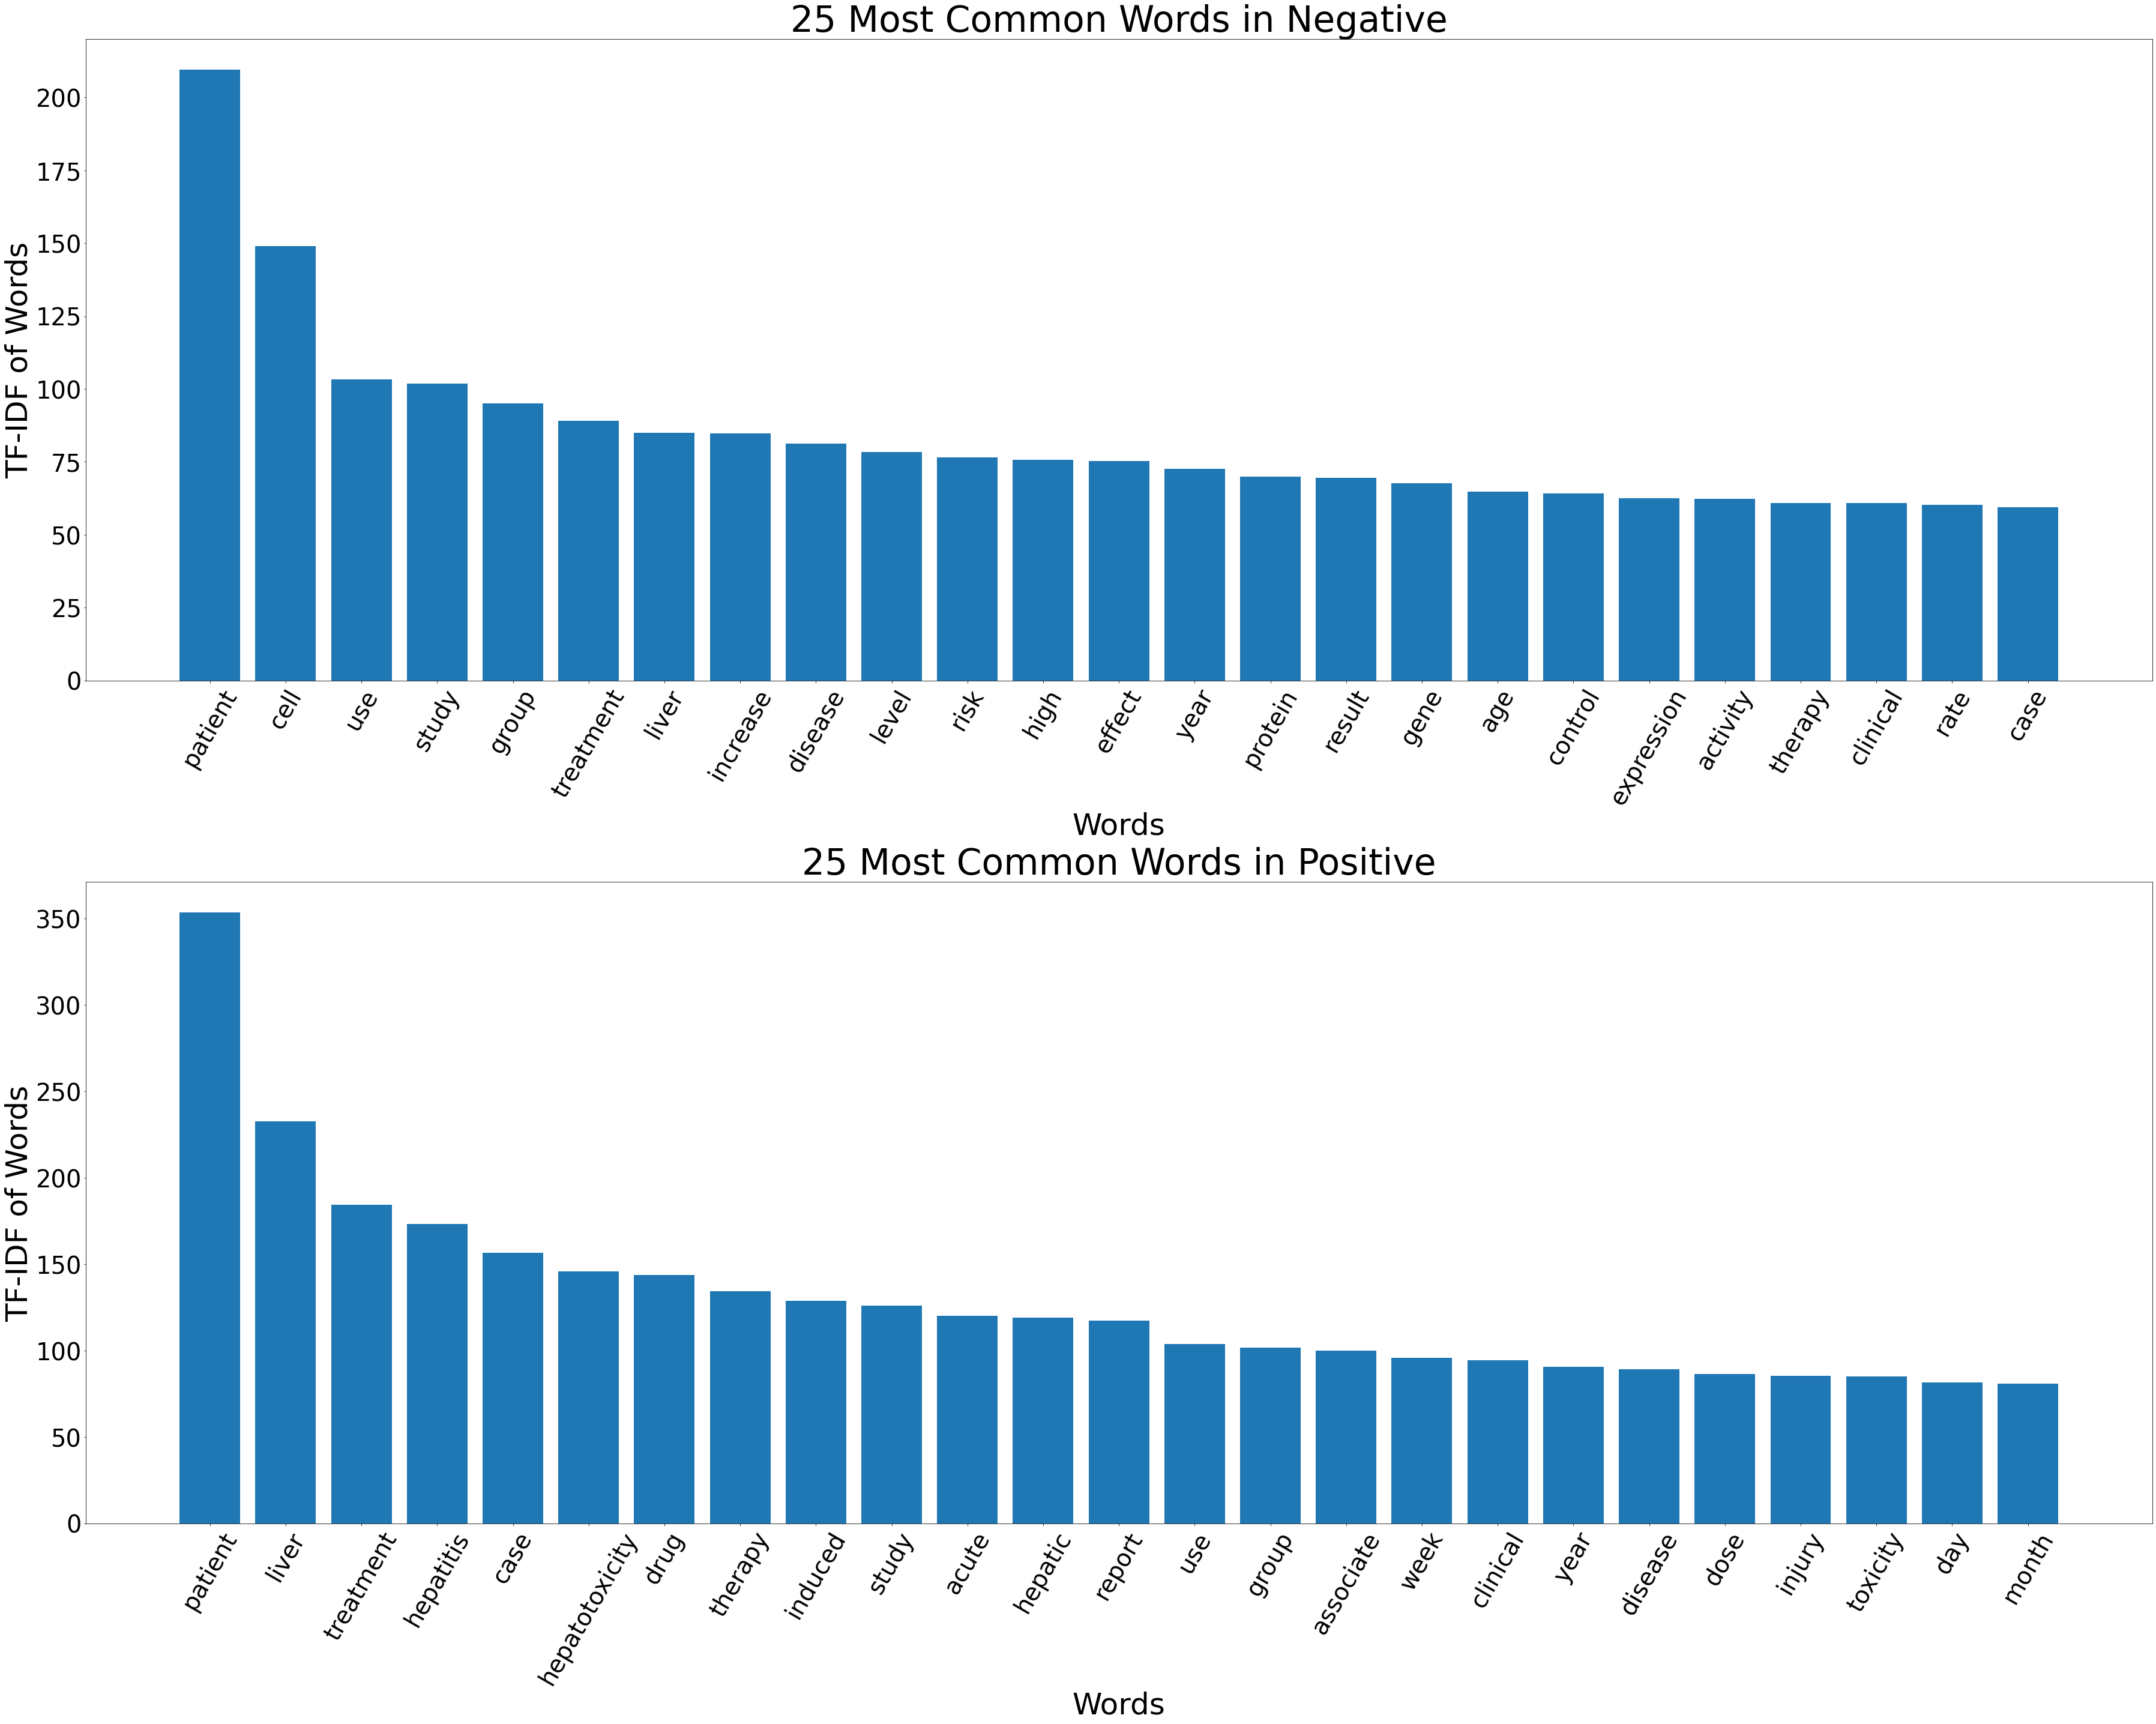

In [48]:
plot_common_words(data)

This is what called "patient-oriented medicine". There are a lot of common words in the most frequent ones, therefore Bag-of-words may be an inefficient strategy, but we will still try it as a baseline model. Embeddings would probably outpreform NBoW.

## Topic Modeling

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data['lemmatized'])

# Create Corpus
texts = data['lemmatized'].values

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [15]:
# Validating different LDA models
model_list, coherence_values = compute_coherence(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=10, step=1)

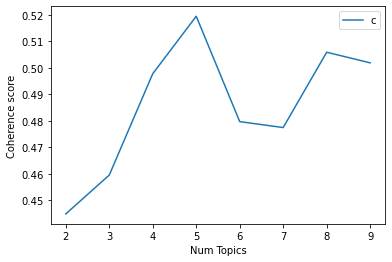

In [16]:
# Finding best number of topics
x = range(2, 10, 1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
for n, v in optimal_model.print_topics(num_words=10):
    print(f'Topic {n+1}')
    print(v + '\n')

Topic 1
0.014*"risk" + 0.012*"study" + 0.010*"age" + 0.010*"year" + 0.009*"data" + 0.008*"woman" + 0.007*"percent" + 0.006*"associate" + 0.006*"child" + 0.006*"high"

Topic 2
0.069*"patient" + 0.029*"treatment" + 0.019*"group" + 0.017*"study" + 0.013*"receive" + 0.011*"week" + 0.011*"therapy" + 0.010*"trial" + 0.009*"month" + 0.009*"placebo"

Topic 3
0.023*"cell" + 0.009*"protein" + 0.009*"expression" + 0.008*"gene" + 0.007*"human" + 0.007*"activity" + 0.006*"show" + 0.005*"role" + 0.005*"suggest" + 0.005*"receptor"

Topic 4
0.018*"level" + 0.016*"increase" + 0.016*"effect" + 0.010*"control" + 0.009*"study" + 0.009*"change" + 0.008*"concentration" + 0.008*"subject" + 0.008*"decrease" + 0.007*"significantly"

Topic 5
0.033*"patient" + 0.030*"liver" + 0.020*"case" + 0.018*"drug" + 0.017*"report" + 0.011*"hepatitis" + 0.010*"hepatic" + 0.010*"disease" + 0.010*"clinical" + 0.010*"associate"



In [26]:
# Visualize the topics
lda_model = wrappers.ldamallet.malletmodel2ldamodel(model_list[3])
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'topic_modelling.html')

/home/wbezshapkin/.conda/envs/dili/lib/python3.6/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/wbezshapkin/.conda/envs/dili/lib/python3.6/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/wbezshapkin/.conda/envs/dili/lib/python3.6/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


# Classification

# 1. Classic ML

## 1.1. SVM (scikit-learn)

In [29]:
pipe_svm = Pipeline([('vect', TfidfVectorizer()), ('clf', SGDClassifier())])

In [30]:
param_grid = {
              'vect__analyzer': ['word', 'char'],
              'vect__smooth_idf': [True, False],
              'vect__max_features': [5000, 10000, 15000, 20000, 25000, 30000],
              'vect__norm': ['l1', 'l2'],  
              'clf__alpha': np.logspace(-5, 3, 9),
              'clf__penalty': ['l1', 'l2', 'elasticnet'],
              'clf__max_iter': np.linspace(10, 200, 20)} 

grid = RandomizedSearchCV(pipe_svm, param_grid, n_iter=1000, cv=10,
                          n_jobs=20, random_state=42, refit=True, verbose=1)
  
# fitting the model for grid search
# grid.fit(X_train, y_train)

In [31]:
# best_svm = grid.best_estimator_

In [32]:
# best_svm

In [33]:
best_svm = Pipeline([('vect', TfidfVectorizer(max_features=25000)), ('clf', SGDClassifier(max_iter=180.0))])
best_svm.fit(X_train, y_train)
best_svm.score(X_test, y_test)

0.9528501055594651

95.2% accuracy with SVM only.  Considering that our dataset was balanced, this is not bad. I decided to use SGD implementation, because it improves training times drastically, which is important for our dataset.  
Let's see what features are responsible for text classification. 

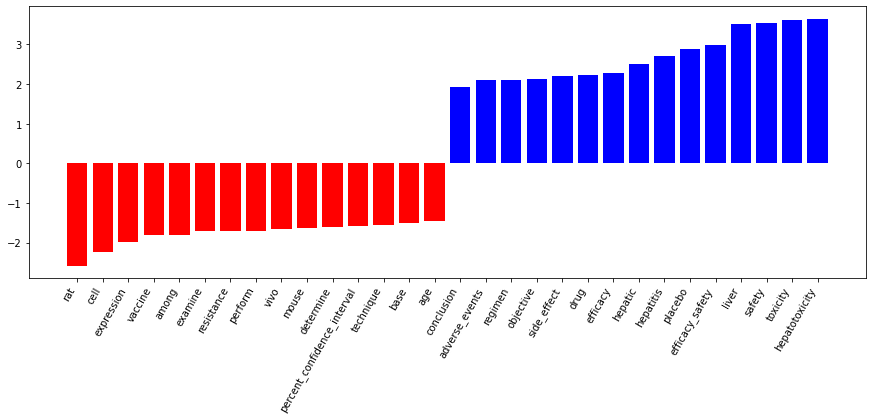

In [56]:
plot_coefficients(best_svm)

## 1.2. Naive Bayes (scikit-learn)

In [21]:
pipe_nb = Pipeline([('vect', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
param_grid = {
              'vect__analyzer': ['word', 'char'],
              'vect__smooth_idf': [True, False],
              'vect__max_features': [5000, 10000, 15000, 20000, 25000, 30000],
              'vect__norm': ['l1', 'l2'],
              'clf__alpha': np.logspace(-5, 2, 8)}
grid = RandomizedSearchCV(pipe_nb, param_grid, n_iter=200, cv=10, 
                          random_state=42, refit=True, verbose=1)
  
# fitting the model for grid search
# grid.fit(X_train, y_train)

In [ ]:
# best_nb = grid.best_estimator_

In [165]:
# best_nb

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=30000, norm='l1',
                                 smooth_idf=False)),
                ('clf', MultinomialNB(alpha=0.01))])

In [23]:
best_nb = Pipeline(steps=[('vect', TfidfVectorizer(max_features=30000, 
                                                   norm='l1',
                                                   smooth_idf=False)),
                          ('clf', MultinomialNB(alpha=0.01))])
best_nb.fit(X_train, y_train)
best_nb.score(X_test, y_test)

0.9514426460239268

95.1% accuracy on Multinomial Naive Bayes, that's a similar result. We will stack both models for a final classificator. 

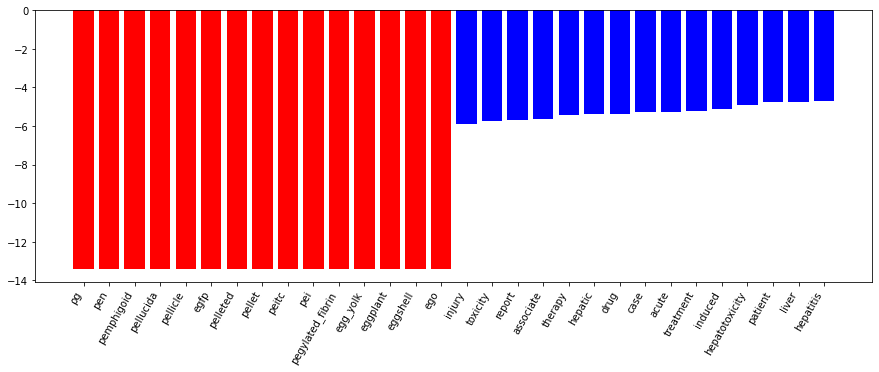

In [59]:
plot_coefficients(best_nb)

So, we are more interested in "patient acute drug hepatotoxicity" than "pemphigoid" or "eggplant".

## 1.3. Stacked Classifier

In [60]:
estimators = [
     ('svc', best_svm),
     ('nb', best_nb)
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [61]:
clf.fit(X_train, y_train).score(X_test, y_test)

0.9549612948627727

In [62]:
with open('./models/stacked-svm-nb.pkl', 'wb') as f:
    pickle.dump(clf, f)

Our stacked classifier reaches 95.5% accuracy, which is decent already. However, we will try to improve using Deep Learning methods.

# 2. Deep Learning

## 2.1. Neural bag of Words (NBOW) - Keras

In [146]:
# Preprocess sentences using Tokenizer
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
_, x_test = prepare_data(x_tr, X_test, model_type='nbow')
x_tr, x_val = prepare_data(x_tr, x_val, model_type='nbow')

In [147]:
nbow = compile_model(x_tr.shape[1], learning_rate=0.0005, model_type='nbow')

In [148]:
nbow.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                1280016   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,280,161
Trainable params: 1,280,161
Non-trainable params: 0
_________________________________________________________________


In [149]:
# Including learning rate decay - so to prevent overfitting
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [150]:
_epochs = 30
_batch_size = 16

history_nbow = nbow.fit(x_tr, y_tr, epochs=_epochs, verbose=0, batch_size=_batch_size,
                    validation_data=(x_val, y_val), 
                    callbacks=[reduce_lr])

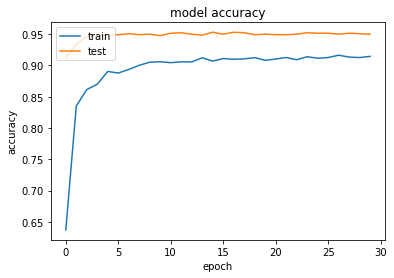

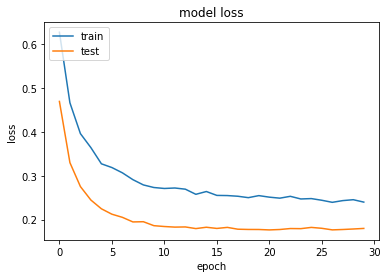

In [151]:
plot_training_curve(history_nbow)

In [152]:
nbow.evaluate(x_test, y_test, batch_size=32)

45/45 [==============================] - 0s 3ms/step - loss: 0.1924 - accuracy: 0.9500


[0.19236423075199127, 0.9500352144241333]

95.0% accuracy. Not great, not terrible. Probably ensembling could improve this score.

In [153]:
nbow.save('./models/nbow.h5')

## 2.2. LSTM text classification

In [155]:
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
_, x_test = prepare_data(x_tr, X_test, model_type='lstm')
x_tr, x_val = prepare_data(x_tr, x_val, model_type='lstm')

In [156]:
lstm = compile_model(x_tr.shape[1], learning_rate=5e-5, model_type='lstm')

In [157]:
lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 256, 512)          40960000  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 256, 512)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 43,059,713
Trainable params: 43,059,713
Non-trainable params: 0
_________________________________________________________________


In [158]:
# Including learning rate decay - so to prevent overfitting
reduce_lr = LearningRateScheduler(lambda x: 5e-5 * 0.9 ** x)

In [159]:
_epochs = 8
_batch_size = 32

history_lstm = lstm.fit(x_tr, y_tr, epochs=_epochs, verbose=0, batch_size=_batch_size,
                    validation_data=(x_val, y_val), 
                    callbacks=[reduce_lr])

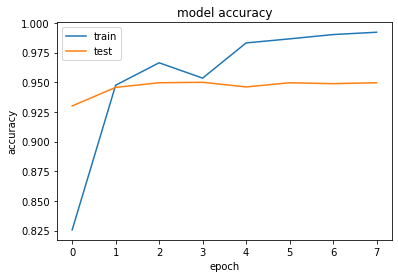

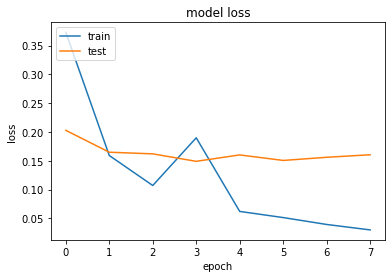

In [160]:
plot_training_curve(history_lstm)

In [161]:
lstm.evaluate(x_test, y_test, batch_size=_batch_size)

45/45 [==============================] - 1s 13ms/step - loss: 0.1564 - accuracy: 0.9507


[0.15641340613365173, 0.9507389068603516]

95.0% and long training times, oh no, that won't work.

In [162]:
lstm.save('./models/lstm.h5')

## 2.3. Bidirectional LSTM

In [163]:
bi_lstm = compile_model(x_tr.shape[1], learning_rate=5e-5, model_type='bi-lstm')

In [164]:
bi_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 256, 512)          40960000  
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 256, 512)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1025      
Total params: 45,159,425
Trainable params: 45,159,425
Non-trainable params: 0
_________________________________________________________________


In [165]:
_epochs = 8
_batch_size = 32

history_bi_lstm = bi_lstm.fit(x_tr, y_tr, epochs=_epochs, verbose=0, batch_size=_batch_size,
                    validation_data=(x_val, y_val), 
                    callbacks=[reduce_lr])

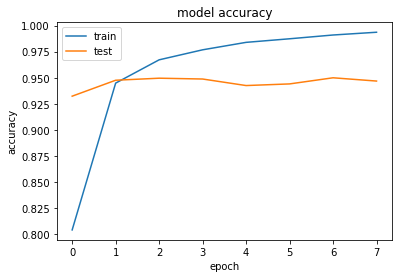

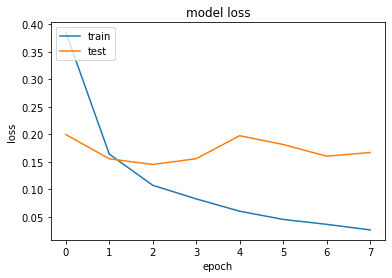

In [166]:
plot_training_curve(history_bi_lstm)

In [167]:
bi_lstm.evaluate(x_test, y_test, batch_size=_batch_size)

45/45 [==============================] - 1s 21ms/step - loss: 0.1477 - accuracy: 0.9585


[0.14769895374774933, 0.9584799408912659]

In [168]:
bi_lstm.save('./models/bi_lstm.h5')